Notebook By: **Cameron Craig**, for ECE 697

This python notebook generates a preset number of synthetic "Bias Fields." These fields will be saved as pickled numpy arrays (yum). These arrays will go on to be read by a Pytorch Dataset object, where they will be multiplied by homogeneous MRI images to simulate the effect of a single posterior coil array capturing the data.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

---

In [3]:
# Fixed Model Parameters
SIZE = (320, 320) # (Height, Width) of the generated bias field
num_points = 250 # resolution of the simulated coil array
coil_left, coil_right = round(SIZE[1]*0.1), round(SIZE[1]*0.9) # horizontal extent of coil array


# Exponential Curve Parameters - Based on Physical Measurements
a = 0.373662089
b = 0.0294170684
c = 57.7187808
d = 0.1090366275

# Uniform Random Variable Bounds
LOW_BOOST_BOUNDS = (0, 0.1)
COIL_VERT_POS_BOUNDS = (SIZE[0] - 1, SIZE[0] * 1.3)
PARAM_B_ADJUST_BOUNDS = (-0.02, 0.02)

In [4]:
# Helper Functions

# Parameterized exponential decay function
def exp_dec(x, a, b, c, d):
  return a*(1 - b)**(x - c) + d

# Normalize pixel values to the range [0, 1]
def normalize(image):
  new_image = image - np.min(image)
  return new_image / np.max(new_image)

# Obtain a sample of a uniform random variable on the specified bounds
def sampleRV(BOUNDS):
  return np.random.uniform(BOUNDS[0], BOUNDS[1])

In [5]:
#Create a Bias Field
def genBiasField(SIZE):
  global a, b, c, d

  # Define Coil Shape
  cx = np.linspace(coil_left, coil_right, num=num_points) # Horizontal coordinates

  # Put coil array at or below bottom edge of bias field
  y_pos = round(sampleRV(COIL_VERT_POS_BOUNDS))
  cy = np.linspace(y_pos, y_pos, num=num_points) # Vertical coordinates

  coils = np.stack([cy, cx], axis=0).T # Reshape to prepare for arithmetic operations

  B = np.zeros(SIZE)
  dists = np.zeros((coils.shape[0],)) # Distances between coil points and field points

  # Exponential curve random perturbations
  local_b = b + sampleRV(PARAM_B_ADJUST_BOUNDS)

  # Loop over all pixels in B
  for i in range(B.shape[0]):
    for j in range(B.shape[1]):
      # Stack of copies of this point's coordinates
      p = np.array([i, j])
      p = np.tile(p, (num_points, 1))

      # Get the distance between this point and the closest coil point
      dist = np.min(np.linalg.norm(coils - p, axis=1))

      # Simulate exponential falloff
      B[i, j] = exp_dec(dist, a, local_b, c, d)
  
  # Normalize B on range [0, 1]
  B_norm = normalize(B)

  # Scale up / boost the weak end intensity of the field
  low_boost = sampleRV(LOW_BOOST_BOUNDS)
  B_boosted = B_norm * (1 - low_boost) + low_boost

  return B_boosted

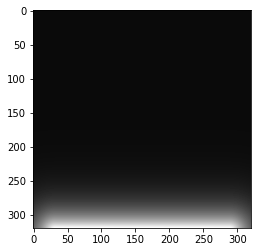

In [6]:
# View a sample
B = genBiasField(SIZE)
plt.imshow(B, cmap='gray', vmin=0, vmax=1)

In [ ]:
# Generate bias field samples for training
NUM_FIELDS = 20

!mkdir ./fields
dir_path = r'./fields'

for i in range(NUM_FIELDS):
  B = genBiasField(SIZE)
  with open(os.path.join(dir_path, 'B_' + str(i) + '.pkl'), 'wb') as curr_file:
    pkl.dump(B, curr_file)